# Named Entity Recognition

### Data were extracted from 3 XML files. Converted to IOB format, tokenized & trained with tensorflow.keras

In [1]:
try: 
    import livelossplot
except:
    !pip install livelossplot
    import livelossplot
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
import xml.etree.ElementTree as ET
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

### Loading the Dataset and IOB Formatting

In [2]:
def extract_xml(xml_doc):
    tree = ET.parse(xml_doc)
    root = tree.getroot()
    text = root.find('TEXT').text
    tags = root.findall('TAGS/*')

    # Create IOB format
    iob_tags = []
    for word in word_tokenize(text):
        # Initialize tag as outside entity (O)
        tag = 'O'
        # Check if word matches any tags
        for t in tags:
             if int(t.attrib['start']) <= text.find(word) < int(t.attrib['end']):
                # Identify tag type
                tag_type = t.attrib['TYPE']
                # Identify tag class (B)
                if tag == 'O':
                    tag = 'B-' + tag_type
        iob_tags.append(tag)
    #Identify tag class (I)    
    for j in range(len(iob_tags)):
        if iob_tags[j] == iob_tags[j-1] and iob_tags[j] != 'O':
            iob_tags[j]= "I-"+iob_tags[j].lower()
            

    #Print IOB format
    word_data = []
    tag_data = []
    sentence = []
    count = 1
    #Print words and tags
    for word, tag in zip(word_tokenize(text), iob_tags):
        word_data.append(word)
        tag_data.append(tag)
    #Print sentence numbers
    for text in word_data:
        sentence.append(f"Sentence: {str(count)}")
        if text == ".":
          count += 1
    #store in DataFrames
    df = pd.DataFrame([sentence,word_data, tag_data]).T
    df.columns = ['sentence_no',"words", "tags"]
    return df

In [3]:
a = extract_xml(xml_doc='file1.xml')
df1 = pd.DataFrame(a)
b = extract_xml(xml_doc = 'file2.xml')
df2 = pd.DataFrame(b)
c = extract_xml(xml_doc = 'file3.xml')
df3 = pd.DataFrame(c)

data = pd.concat([df3,df2,df1], ignore_index=True)

In [4]:
data.head(10)

,sentence_no,words,tags
0,Sentence: 1,Record,O
1,Sentence: 1,date,O
2,Sentence: 1,:,O
3,Sentence: 1,2109-09-14,B-DATE
4,Sentence: 1,September,I-b-date
5,Sentence: 1,14,B-DATE
6,Sentence: 1,",",I-b-date
7,Sentence: 1,2109,B-DATE
8,Sentence: 1,Vicente,B-DOCTOR
9,Sentence: 1,Blair,I-b-doctor


In [5]:
data.sentence_no.value_counts()

Sentence: 2     137
Sentence: 10    108
Sentence: 3      87
Sentence: 22     79
Sentence: 24     68
               ... 
Sentence: 41      2
Sentence: 42      2
Sentence: 43      2
Sentence: 69      2
Sentence: 79      2
Name: sentence_no, Length: 90, dtype: int64

In [6]:
data.shape

(2644, 3)

In [7]:
data.tags.unique()

array(['O', 'B-DATE', 'I-b-date', 'B-DOCTOR', 'I-b-doctor', 'B-HOSPITAL',
       'I-b-hospital', 'B-CITY', 'B-STATE', 'B-ZIP', 'B-PATIENT',
       'B-MEDICALRECORD', 'I-b-patient', 'B-AGE', 'B-PROFESSION',
       'I-b-profession', 'B-IDNUM', 'I-b-idnum', 'B-USERNAME', 'B-STREET',
       'I-b-street', 'B-ORGANIZATION', 'I-b-organization'], dtype=object)

In [8]:
data.isnull().sum()

sentence_no    0
words          0
tags           0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_no  2644 non-null   object
 1   words        2644 non-null   object
 2   tags         2644 non-null   object
dtypes: object(3)
memory usage: 62.1+ KB


In [10]:
data['tags'].value_counts() #Not balanced

O                   2322
B-DATE               112
B-PATIENT             71
B-HOSPITAL            53
B-DOCTOR              14
B-AGE                  9
I-b-doctor             9
B-ZIP                  8
I-b-hospital           7
I-b-patient            6
I-b-date               5
B-CITY                 5
B-STREET               4
B-MEDICALRECORD        3
B-STATE                3
B-PROFESSION           2
I-b-profession         2
B-IDNUM                2
B-USERNAME             2
I-b-street             2
I-b-idnum              1
B-ORGANIZATION         1
I-b-organization       1
Name: tags, dtype: int64

In [11]:
len(data['tags'].value_counts())

23

In [12]:
agg_func = lambda s:[(a, b) for a,b in zip(s["words"].values.tolist(),s['tags'].values.tolist())]

In [13]:
agg_data=data.groupby(['sentence_no']).apply(agg_func).reset_index().rename(columns={0:'word_tag_pair'})
agg_data.head()

,sentence_no,word_tag_pair
0,Sentence: 1,"[(Record, O), (date, O), (:, O), (2109-09-14, ..."
1,Sentence: 10,"[(Mr., O), (Valdez, B-PATIENT), (underwent, O)..."
2,Sentence: 11,"[(In, O), (addition, O), (,, B-DATE), (loud, O..."
3,Sentence: 12,"[(There, O), (was, O), (evidence, O), (of, O),..."
4,Sentence: 13,"[(There, O), (was, O), (a, O), (predominance, ..."


In [14]:
agg_data['sentence']=agg_data['word_tag_pair'].apply(lambda sentence:" ".join([s[0] for s in sentence]))
agg_data['tags']=agg_data['word_tag_pair'].apply(lambda sentence:" ".join([s[1] for s in sentence]))

In [15]:
agg_data.shape

(90, 4)

In [16]:
agg_data.head()

,sentence_no,word_tag_pair,sentence,tags
0,Sentence: 1,"[(Record, O), (date, O), (:, O), (2109-09-14, ...","Record date : 2109-09-14 September 14 , 2109 V...",O O O B-DATE I-b-date B-DATE I-b-date B-DATE B...
1,Sentence: 10,"[(Mr., O), (Valdez, B-PATIENT), (underwent, O)...",Mr. Valdez underwent an initial formal polysom...,O B-PATIENT O B-PATIENT O O O O O O O O O O O ...
2,Sentence: 11,"[(In, O), (addition, O), (,, B-DATE), (loud, O...","In addition , loud snoring was noted . REVIEW ...",O O B-DATE O O O O O O O O O O O O O O B-PATIE...
3,Sentence: 12,"[(There, O), (was, O), (evidence, O), (of, O),...",There was evidence of a sleep efficiency of 88...,O O O O O O O O O O O O O O O O O B-DATE O O O...
4,Sentence: 13,"[(There, O), (was, O), (a, O), (predominance, ...",There was a predominance of `` light '' non-RE...,O O O O O O O O O O O O B-DATE O O O O B-HOSPI...


In [17]:
agg_data['tokenised_sentences']=agg_data['sentence'].apply(lambda x:x.split())
agg_data['tag_list']=agg_data['tags'].apply(lambda x:x.split())
agg_data.head()

,sentence_no,word_tag_pair,sentence,tags,tokenised_sentences,tag_list
0,Sentence: 1,"[(Record, O), (date, O), (:, O), (2109-09-14, ...","Record date : 2109-09-14 September 14 , 2109 V...",O O O B-DATE I-b-date B-DATE I-b-date B-DATE B...,"[Record, date, :, 2109-09-14, September, 14, ,...","[O, O, O, B-DATE, I-b-date, B-DATE, I-b-date, ..."
1,Sentence: 10,"[(Mr., O), (Valdez, B-PATIENT), (underwent, O)...",Mr. Valdez underwent an initial formal polysom...,O B-PATIENT O B-PATIENT O O O O O O O O O O O ...,"[Mr., Valdez, underwent, an, initial, formal, ...","[O, B-PATIENT, O, B-PATIENT, O, O, O, O, O, O,..."
2,Sentence: 11,"[(In, O), (addition, O), (,, B-DATE), (loud, O...","In addition , loud snoring was noted . REVIEW ...",O O B-DATE O O O O O O O O O O O O O O B-PATIE...,"[In, addition, ,, loud, snoring, was, noted, ....","[O, O, B-DATE, O, O, O, O, O, O, O, O, O, O, O..."
3,Sentence: 12,"[(There, O), (was, O), (evidence, O), (of, O),...",There was evidence of a sleep efficiency of 88...,O O O O O O O O O O O O O O O O O B-DATE O O O...,"[There, was, evidence, of, a, sleep, efficienc...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Sentence: 13,"[(There, O), (was, O), (a, O), (predominance, ...",There was a predominance of `` light '' non-RE...,O O O O O O O O O O O O B-DATE O O O O B-HOSPI...,"[There, was, a, predominance, of, ``, light, '...","[O, O, O, O, O, O, O, O, O, O, O, O, B-DATE, O..."


In [18]:
agg_data['len_sentence']=agg_data['tokenised_sentences'].apply(lambda x:len(x))
agg_data['len_tag']=agg_data['tag_list'].apply(lambda x:len(x))
agg_data['is_equal']=agg_data.apply(lambda row:1 if row['len_sentence']==row['len_tag'] else 0,axis=1)
agg_data['is_equal'].value_counts()

1    90
Name: is_equal, dtype: int64

In [19]:
agg_data.shape

(90, 9)

In [20]:
sentences_list=agg_data['tokenised_sentences'].tolist()
tags_list=agg_data['tag_list'].tolist()

print("Number of Sentences in the Data: ",len(sentences_list))
print("Are number of Sentences and Tag list equal: ",len(sentences_list)==len(tags_list))

Number of Sentences in the Data:  90
Are number of Sentences and Tag list equal:  True


In [21]:
#Checks
len(sentences_list[15]) == len(tags_list[15])

True

In [22]:
len(sentences_list[50]) == len(tags_list[50])

True

In [23]:
len(sentences_list[30]) == len(tags_list[30])

True

In [24]:
len(sentences_list[0]) == len(tags_list[0]) # Collins you are good to build

True

### Building The Model

In [25]:
tokeniser= tf.keras.preprocessing.text.Tokenizer(lower=False,filters='')
tokeniser.fit_on_texts(sentences_list)

In [26]:
print("Vocabulary size of Tokeniser ",len(tokeniser.word_index)+1) # Adding one since 0 is reserved for padding

Vocabulary size of Tokeniser  900


In [27]:
tokeniser.index_word[15]

'The'

In [28]:
encoded_sentence=tokeniser.texts_to_sequences(sentences_list)
print("First Original Sentence: \n", sentences_list[0])
print("First Encoded Sentence:\n", encoded_sentence[0])
print("Is Length of Original Sentence Same as Encoded Sentence: ",len(sentences_list[0])==len(encoded_sentence[0]))
print("Length of First Sentence: ", len(encoded_sentence[0]))

First Original Sentence: 
 ['Record', 'date', ':', '2109-09-14', 'September', '14', ',', '2109', 'Vicente', 'Blair', ',', 'M.D', '.', 'Record', 'date', ':', '2108-03-14', 'CAMPBELL', 'EMERGENCY', 'DEPT', 'VISIT', 'VALDEZ', ',', 'HARLAN', ',', 'JR', '.', 'Record', 'date', ':', '2106-02-12', 'Campbell', 'Orthopedic', 'Associates', '4', 'Madera', 'Circle', 'Omak', ',', 'GA', '28172', 'Habib', 'Valenzuela', ',', 'M.D', '.']
First Encoded Sentence:
 [117, 118, 12, 349, 350, 351, 2, 352, 186, 353, 2, 35, 1, 117, 118, 12, 354, 355, 356, 357, 119, 187, 2, 358, 2, 359, 1, 117, 118, 12, 360, 361, 362, 363, 88, 364, 365, 120, 2, 188, 366, 121, 122, 2, 35, 1]
Is Length of Original Sentence Same as Encoded Sentence:  True
Length of First Sentence:  46


In [29]:
tags=list(set(data["tags"].values))
print(tags)

['B-ZIP', 'I-b-street', 'I-b-patient', 'B-MEDICALRECORD', 'B-IDNUM', 'I-b-idnum', 'I-b-hospital', 'I-b-profession', 'B-STATE', 'B-AGE', 'B-HOSPITAL', 'B-USERNAME', 'B-ORGANIZATION', 'B-STREET', 'O', 'B-CITY', 'B-DATE', 'B-PATIENT', 'I-b-date', 'B-DOCTOR', 'I-b-doctor', 'I-b-organization', 'B-PROFESSION']


In [30]:
num_tags=len(tags)
print("Number of Tags: ",num_tags)

Number of Tags:  23


In [31]:
tags_map={tag:i for i,tag in enumerate(tags)}
print("Tags Map: ",tags_map)

Tags Map:  {'B-ZIP': 0, 'I-b-street': 1, 'I-b-patient': 2, 'B-MEDICALRECORD': 3, 'B-IDNUM': 4, 'I-b-idnum': 5, 'I-b-hospital': 6, 'I-b-profession': 7, 'B-STATE': 8, 'B-AGE': 9, 'B-HOSPITAL': 10, 'B-USERNAME': 11, 'B-ORGANIZATION': 12, 'B-STREET': 13, 'O': 14, 'B-CITY': 15, 'B-DATE': 16, 'B-PATIENT': 17, 'I-b-date': 18, 'B-DOCTOR': 19, 'I-b-doctor': 20, 'I-b-organization': 21, 'B-PROFESSION': 22}


In [32]:
reverse_tag_map={v: k for k, v in tags_map.items()}

In [33]:
encoded_tags=[[tags_map[w] for w in tag] for tag in tags_list]
print("First Sentence:\n",sentences_list[0])
print('First Sentence Original Tags:\n',tags_list[0])
print("First Sentence Encoded Tags:\n ",encoded_tags[0])
print("Is length of Original Tags and Encoded Tags same: ",len(tags_list[0])==len(encoded_tags[0]))
print("Length of Tags for First Sentence: ",len(encoded_tags[0]))

First Sentence:
 ['Record', 'date', ':', '2109-09-14', 'September', '14', ',', '2109', 'Vicente', 'Blair', ',', 'M.D', '.', 'Record', 'date', ':', '2108-03-14', 'CAMPBELL', 'EMERGENCY', 'DEPT', 'VISIT', 'VALDEZ', ',', 'HARLAN', ',', 'JR', '.', 'Record', 'date', ':', '2106-02-12', 'Campbell', 'Orthopedic', 'Associates', '4', 'Madera', 'Circle', 'Omak', ',', 'GA', '28172', 'Habib', 'Valenzuela', ',', 'M.D', '.']
First Sentence Original Tags:
 ['O', 'O', 'O', 'B-DATE', 'I-b-date', 'B-DATE', 'I-b-date', 'B-DATE', 'B-DOCTOR', 'I-b-doctor', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'B-HOSPITAL', 'O', 'O', 'O', 'B-PATIENT', 'I-b-patient', 'B-PATIENT', 'I-b-patient', 'B-PATIENT', 'I-b-patient', 'O', 'O', 'O', 'B-DATE', 'B-HOSPITAL', 'O', 'O', 'B-STREET', 'I-b-street', 'B-STREET', 'B-CITY', 'O', 'B-STATE', 'B-ZIP', 'B-DOCTOR', 'I-b-doctor', 'O', 'O', 'O']
First Sentence Encoded Tags:
  [14, 14, 14, 16, 18, 16, 18, 16, 19, 20, 16, 14, 14, 14, 14, 14, 16, 10, 14, 14, 14, 17, 2, 17, 2, 17, 2, 1

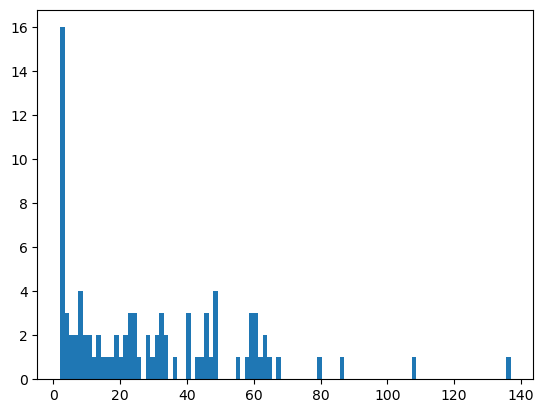

In [34]:
plt.hist([len(sen) for sen in sentences_list], bins= 100)
plt.show()

In [35]:
max_sentence_length=max([len(s) for s in sentences_list])
max_len = max_sentence_length
print(max_sentence_length)

137


In [36]:
tags_map

{'B-ZIP': 0,
 'I-b-street': 1,
 'I-b-patient': 2,
 'B-MEDICALRECORD': 3,
 'B-IDNUM': 4,
 'I-b-idnum': 5,
 'I-b-hospital': 6,
 'I-b-profession': 7,
 'B-STATE': 8,
 'B-AGE': 9,
 'B-HOSPITAL': 10,
 'B-USERNAME': 11,
 'B-ORGANIZATION': 12,
 'B-STREET': 13,
 'O': 14,
 'B-CITY': 15,
 'B-DATE': 16,
 'B-PATIENT': 17,
 'I-b-date': 18,
 'B-DOCTOR': 19,
 'I-b-doctor': 20,
 'I-b-organization': 21,
 'B-PROFESSION': 22}

In [37]:
max_len
padded_encoded_sentences = pad_sequences(maxlen=max_len,sequences=encoded_sentence,padding="post",value=0)

In [38]:
padded_encoded_tags=pad_sequences(maxlen=max_len,sequences=encoded_tags,padding="post",value=0)

print("Shape of Encoded Sentence: ",padded_encoded_sentences.shape)
print("Shape of Encoded Labels: ",padded_encoded_tags.shape)

print("First Encoded Sentence Without Padding:\n",encoded_sentence[0])
print("First Encoded Sentence with padding:\n",padded_encoded_sentences[0])
print("First Sentence Encoded Label without Padding:\n",encoded_tags[0])
print("First Sentence Encoded Label with Padding:\n",padded_encoded_tags[0])

Shape of Encoded Sentence:  (90, 137)
Shape of Encoded Labels:  (90, 137)
First Encoded Sentence Without Padding:
 [117, 118, 12, 349, 350, 351, 2, 352, 186, 353, 2, 35, 1, 117, 118, 12, 354, 355, 356, 357, 119, 187, 2, 358, 2, 359, 1, 117, 118, 12, 360, 361, 362, 363, 88, 364, 365, 120, 2, 188, 366, 121, 122, 2, 35, 1]
First Encoded Sentence with padding:
 [117 118  12 349 350 351   2 352 186 353   2  35   1 117 118  12 354 355
 356 357 119 187   2 358   2 359   1 117 118  12 360 361 362 363  88 364
 365 120   2 188 366 121 122   2  35   1   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
First Sentence Encoded Label without Padding:
 [14, 14, 14, 16, 18, 16, 18, 16, 19,

In [39]:
target= [to_categorical(i,num_classes = num_tags) for i in  padded_encoded_tags]
print("Shape of Labels  after converting to Categorical for first sentence: ",target[0].shape)

Shape of Labels  after converting to Categorical for first sentence:  (137, 23)


### Splitting The Data

In [40]:
X_train,X_val_test,y_train,y_val_test = train_test_split(padded_encoded_sentences,target,test_size = 0.2,random_state=False)
X_val,X_test,y_val,y_test = train_test_split(X_val_test,y_val_test,test_size = 0.2,random_state=True)
print("Input Train Data Shape: ",X_train.shape)
print("Train Labels Length: ",len(y_train))
print("Input Test Data Shape: ",X_test.shape)
print("Test Labels Length: ",len(y_test))
print("Input Validation Data Shape: ",X_val.shape)
print("Validation Labels Length: ",len(y_val))

Input Train Data Shape:  (72, 137)
Train Labels Length:  72
Input Test Data Shape:  (4, 137)
Test Labels Length:  4
Input Validation Data Shape:  (14, 137)
Validation Labels Length:  14


In [41]:
print("First Sentence in Training Data: ",X_train[0])
print("First sentence Label: ",y_train[0])
print("Shape of First Sentence -Train: ",X_train[0].shape)
print("Shape of First Sentence Label  -Train: ",y_train[0].shape)

First Sentence in Training Data:  [ 16 177   4  44   3   4  23 109 827  24 828  18 829 235 328  32  47  48
 830   4 831  10 832   8  62   7 833  18   7  54   1  16  30  45 326  91
  41   2  32  21  26 104  20   4 265   3 343 142  73 834   1  16  26   4
  44   3 287   6   7 835   1   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
First sentence Label:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Shape of First Sentence -Train:  (137,)
Shape of First Sentence Label  -Train:  (137, 23)


### Training The Model

In [42]:
embedding_dim = max_len
vocab_size=len(tokeniser.word_index)+1
#lstm_units = max_len
max_len = 137

input_word = Input(shape = (max_len,))
model = Embedding(input_dim = vocab_size+1,output_dim = embedding_dim,input_length = max_len)(input_word)

model = Bidirectional(LSTM(units=embedding_dim,return_sequences=True))(model)
output = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 137)]             0         
                                                                 
 embedding (Embedding)       (None, 137, 137)          123437    
                                                                 
 bidirectional (Bidirectiona  (None, 137, 274)         301400    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 137, 23)          6325      
 ibuted)                                                         
                                                                 
Total params: 431,162
Trainable params: 431,162
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

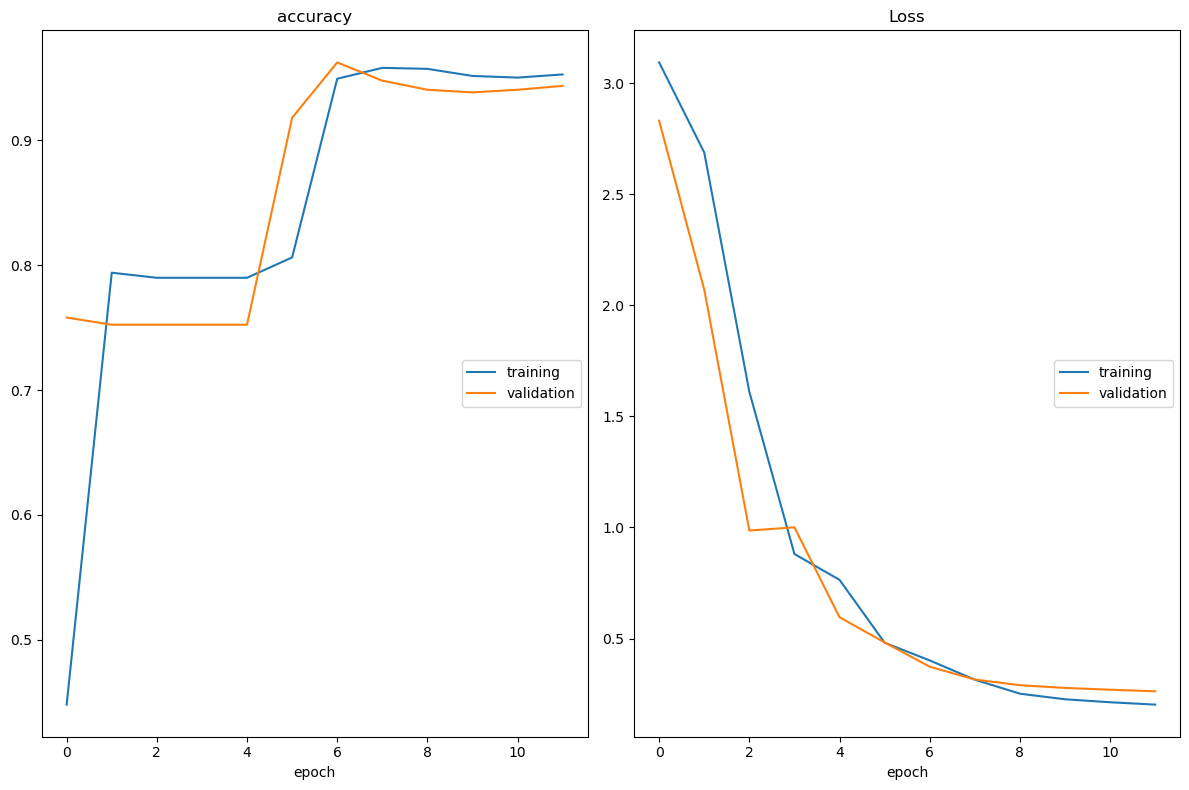

accuracy
	training         	 (min:    0.448, max:    0.958, cur:    0.953)
	validation       	 (min:    0.752, max:    0.962, cur:    0.944)
Loss
	training         	 (min:    0.202, max:    3.093, cur:    0.202)
	validation       	 (min:    0.262, max:    2.831, cur:    0.262)
3/3 [==============================] - 1s 413ms/step - loss: 0.2024 - accuracy: 0.9529 - val_loss: 0.2624 - val_accuracy: 0.9437
Epoch 12: early stopping
Wall time: 17.1 s


In [44]:
%%time
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=2, mode='min', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]
history = model.fit(
    X_train,
    np.array(y_train),
    validation_data=(X_val,np.array(y_val)),
    batch_size = 32,
    epochs = 500,
    callbacks=callbacks,
    verbose=1)

### Evaluating The Model

In [45]:
y_pred=model.predict(X_test) ## Predict using collins_medicalNER model on Test Data

1/1 [==============================] - 1s 733ms/step


In [46]:
## Create a Pickle file using serialization 
#import pickle
#pickle_out = open("model.pkl","wb")
#pickle.dump(model, pickle_out)
#pickle_out.close()

In [47]:
def collins_Predictionevaluation(test_data,preds,actual_preds):
    #print(actual_preds)
    #print("Shape of Test Data Array",test_data.shape)
    #print("Shape of Test Data Array",preds)
    y_actual=np.argmax(np.array(actual_preds),axis=2)
    y_pred=np.argmax(preds,axis=2)
    num_test_data=test_data.shape[0]
    #print("Number of Test Data Points: ",num_test_data)
    data=pd.DataFrame()
    df_list=[]
    for i in range(num_test_data):
        test_str=list(test_data[i])
        df=pd.DataFrame()
        df['test_tokens']=test_str
        df['tokens']=df['test_tokens'].apply(lambda x:tokeniser.index_word[x] if x!=0 else '<PAD>')
        df['actual_target_index']=list(y_actual[i])
        df['pred_target_index']=list(y_pred[i])
        df['actual_target_tag']=df['actual_target_index'].apply(lambda x:reverse_tag_map[x])
        df['pred_target_tag']=df['pred_target_index'].apply(lambda x:reverse_tag_map[x])
        df['id']=i+1
        df_list.append(df)
    data=pd.concat(df_list)
    pred_data=data[data['tokens']!='<PAD>']
    accuracy=pred_data[pred_data['actual_target_tag']==pred_data['pred_target_tag']].shape[0]/pred_data.shape[0]
    
    
    return pred_data,accuracy

In [48]:
pred_data,accuracy = collins_Predictionevaluation(X_test,y_pred,y_test)

In [49]:
y_pred=pred_data['pred_target_tag'].tolist()
y_actual=pred_data['actual_target_tag'].tolist()

In [50]:
print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00         5
  B-HOSPITAL       0.00      0.00      0.00         2
           O       0.92      1.00      0.96        82

    accuracy                           0.92        89
   macro avg       0.31      0.33      0.32        89
weighted avg       0.85      0.92      0.88        89



In [51]:
pred_data.tail(10)

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
6,272,normal,14,14,O,O,4
7,710,based,14,14,O,O,4
8,2,",",16,14,B-DATE,O,4
9,142,without,14,14,O,O,4
10,42,evidence,14,14,O,O,4
11,3,of,14,14,O,O,4
12,73,significant,14,14,O,O,4
13,324,gait,14,14,O,O,4
14,323,dystaxias,14,14,O,O,4
15,1,.,14,14,O,O,4


In [52]:
print("Accuracy for Collins_MedicalNER Model Test Sample is: ", accuracy)

Accuracy for Collins_MedicalNER Model Test Sample is:  0.9213483146067416
